In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from wilds.common.grouper import CombinatorialGrouper
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from tqdm import tqdm
from erm_helpers import *
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import sys
import os
import time
from Classifier import Classifier
from SubsampledDataset import SubsampledDataset
from torchsummary import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# device = "cpu"
BATCH_SIZE = 64

cuda


<font size="6">Load train and validation data</font>

In [3]:
dataset = get_dataset(dataset="fmow", download=False)
grouper = CombinatorialGrouper(dataset, ["region"])

train_data = dataset.get_subset(
    "train",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

ood_val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

id_val_data = dataset.get_subset(
    "id_val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

# train_dataset = SubsampledDataset(train_data, grouper)
# ood_val_dataset = SubsampledDataset(ood_val_data, grouper)
# id_val_dataset = SubsampledDataset(id_val_data, grouper)

train_dataset = torch.load("subsampled_data/train.pt")
ood_val_dataset = torch.load("subsampled_data/ood_val.pt")
id_val_dataset = torch.load("subsampled_data/id_val.pt")

train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)
ood_val_loader   = get_train_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader    = get_train_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)

<font size="6">Train and accumulate evaluation per epoch</font>

In [4]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
MODEL_PATH = "models"
NUM_CLASSES = 10
MOMENTUM = 0.9

model = Classifier(NUM_CLASSES, use_pretrained=True, freeze_encoder=True)
model.to(device)

# summary = summary(model, (3, 224, 224))

model_name = f"ERM_{NUM_CLASSES}_{NUM_EPOCHS}_SGD_{LEARNING_RATE}_{MOMENTUM}_CrossEntropy_with_unet_with_selfsup_frozen.pth"
save_name = os.path.join(MODEL_PATH, model_name)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

train_evolution = []
val_evolution = []
id_val_evolution = []
best_loss = sys.float_info.max

for epoch in range(NUM_EPOCHS):
	print(f"EPOCH {epoch + 1}:")
	# train
	y_true, y_pred, metadata, loss = train_step(model, train_loader, loss_fn, optimizer, device)
	train_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"Train Loss: {loss}")

	# validation
	y_true, y_pred, metadata, loss = val_step(model, ood_val_loader, loss_fn, device)
	val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"OOD Loss: {loss}")

	# # save by best ood loss
	if loss < best_loss:
		best_loss = loss
		torch.save(model, save_name)

	# in distribution validation
	y_true, y_pred, metadata, loss = val_step(model, id_val_loader, loss_fn, device)
	id_val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"ID Loss: {loss}")



EPOCH 1:


100%|██████████| 345/345 [02:04<00:00,  2.76it/s]


Train Loss: 1.843825940809388


100%|██████████| 91/91 [00:32<00:00,  2.79it/s]


OOD Loss: 1.8836964080621907


100%|██████████| 53/53 [00:18<00:00,  2.87it/s]


ID Loss: 1.95659128674921
EPOCH 2:


100%|██████████| 345/345 [02:11<00:00,  2.62it/s]


Train Loss: 0.8963585910589799


100%|██████████| 91/91 [00:32<00:00,  2.82it/s]


OOD Loss: 1.8670088131349165


100%|██████████| 53/53 [00:18<00:00,  2.82it/s]


ID Loss: 1.9386183563268409
EPOCH 3:


100%|██████████| 345/345 [02:07<00:00,  2.71it/s]


Train Loss: 0.5584650034057921


100%|██████████| 91/91 [00:33<00:00,  2.70it/s]


OOD Loss: 1.980544428248982


100%|██████████| 53/53 [00:19<00:00,  2.75it/s]


ID Loss: 2.013538754211282
EPOCH 4:


100%|██████████| 345/345 [02:07<00:00,  2.71it/s]


Train Loss: 0.3707771313795145


100%|██████████| 91/91 [00:32<00:00,  2.81it/s]


OOD Loss: 1.9311837691527147


100%|██████████| 53/53 [00:18<00:00,  2.80it/s]


ID Loss: 2.0252007403463685
EPOCH 5:


100%|██████████| 345/345 [02:07<00:00,  2.71it/s]


Train Loss: 0.2685953509116518


100%|██████████| 91/91 [00:33<00:00,  2.73it/s]


OOD Loss: 1.9253268464580997


100%|██████████| 53/53 [00:18<00:00,  2.88it/s]


ID Loss: 2.0063523099107563
EPOCH 6:


100%|██████████| 345/345 [02:07<00:00,  2.71it/s]


Train Loss: 0.20738581604715706


100%|██████████| 91/91 [00:33<00:00,  2.68it/s]


OOD Loss: 1.8628364133310842


100%|██████████| 53/53 [00:19<00:00,  2.70it/s]


ID Loss: 1.916790174988081
EPOCH 7:


100%|██████████| 345/345 [02:07<00:00,  2.70it/s]


Train Loss: 0.16610880742470424


100%|██████████| 91/91 [00:33<00:00,  2.76it/s]


OOD Loss: 1.8716285123929872


100%|██████████| 53/53 [00:18<00:00,  2.90it/s]


ID Loss: 1.9437002708327096
EPOCH 8:


100%|██████████| 345/345 [02:07<00:00,  2.71it/s]


Train Loss: 0.13858533608524695


100%|██████████| 91/91 [00:32<00:00,  2.77it/s]


OOD Loss: 1.9021435845029222


100%|██████████| 53/53 [00:19<00:00,  2.69it/s]


ID Loss: 1.9681003611042815
EPOCH 9:


100%|██████████| 345/345 [02:06<00:00,  2.72it/s]


Train Loss: 0.11296175991495451


100%|██████████| 91/91 [00:32<00:00,  2.79it/s]


OOD Loss: 1.890643590099209


100%|██████████| 53/53 [00:18<00:00,  2.80it/s]


ID Loss: 1.9618691813271
EPOCH 10:


100%|██████████| 345/345 [02:07<00:00,  2.71it/s]


Train Loss: 0.10804407081526259


100%|██████████| 91/91 [00:33<00:00,  2.72it/s]


OOD Loss: 1.9919712451788096


100%|██████████| 53/53 [00:19<00:00,  2.72it/s]

ID Loss: 2.031497359275818


<font size="6">Plot loss and accuracy per region</font>

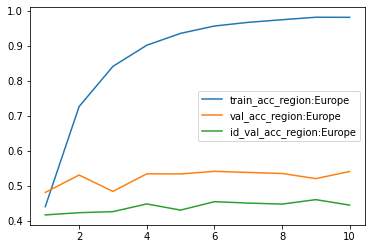

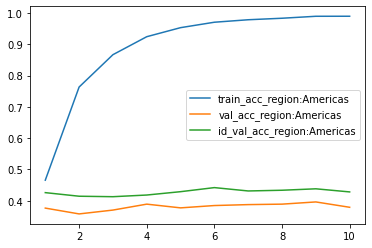

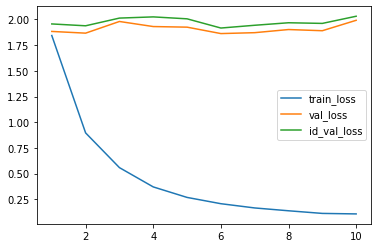

In [5]:
metrics = list(train_evolution[0].keys())

for metric in metrics:
	plot_graph(metric, train_evolution, val_evolution, id_val_evolution, NUM_EPOCHS)